In [2]:
# cd to the JANUS main directory!!!
%cd ${PATH_TO_JANUS}

[WinError 2] The system cannot find the file specified: '${PATH_TO_JANUS}'
c:\Users\ivan.smaliakou\OneDrive - Selvita S.A\Pulpit\src\JANUS


In [3]:
from janus import JANUS, utils
from rdkit import Chem, RDLogger
from rings_filters.rings import filter_rings
import pandas as pd
import numpy as np
import selfies
import joblib
import torch
import re
from rdkit.Chem import AllChem, RDConfig, Descriptors, QED
from rdkit.Contrib.SA_Score import sascorer
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogEntry, RunFilterCatalog, SmartsMatcher

RDLogger.DisableLog("rdApp.*")

from rdkit.DataStructs import TanimotoSimilarity

FILTERS_PATH = './filters/rd_filters.csv'
ACTIVITY_SCORE_MULT = 2.0
rd_filters = pd.read_csv(FILTERS_PATH)

chembl_rings = pd.read_pickle('./rings_filters/chembl_rings.pkl')
filters = FilterCatalog()
for i, row in rd_filters.iterrows():
    matcher = SmartsMatcher('', row['smarts'])
    entry = FilterCatalogEntry(row['description'], matcher)
    filters.AddEntry(entry)

print(f'Cuda is available: {torch.cuda.is_available()}')

def get_atom_chars(smi):
    atoms_chars=[]
    mol = Chem.MolFromSmiles(smi,sanitize=False)
    for a in mol.GetAtoms():
        atom=Chem.RWMol()
        atom.AddAtom(a)
        atoms_chars.append(Chem.MolToSmiles(atom))
    return atoms_chars

def has_radicals(mol):
    for atom in mol.GetAtoms():
      if atom.GetNumRadicalElectrons() > 0:
        return True
    return False

def is_neutral(mol):
  for atom in mol.GetAtoms():
    charge = atom.GetFormalCharge()
    if charge != 0:
      return False  # Atom is charged
  return True  # All atoms are neutral

def is_organic(mol):
    allowed_elements = {'H', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I'}
    for atom in mol.GetAtoms():
        if atom.GetSymbol() not in allowed_elements:
            return False
    return True
patterns = [Chem.MolFromSmarts('[#6,O]-[P](=[O,N])(=[O,N])-[O,N]'), Chem.MolFromSmarts('[#6]-[SX2]-[#6]'), Chem.MolFromSmarts('[#6]-[SX3](=O)-[#6]'),
             Chem.MolFromSmarts('[#6]-[S](=[O])(=[O])-N'), Chem.MolFromSmarts('[sX2]'), Chem.MolFromSmarts('[sX3]'), Chem.MolFromSmarts('[P]'),
               Chem.MolFromSmarts('[r3]=[r3]'), Chem.MolFromSmarts('[r4]=[r4]'), Chem.MolFromSmarts('[r]#[r]'), Chem.MolFromSmarts('[*]=[#6]=[*]'),
               Chem.MolFromSmarts('[#6]-1=[#6]-[#6]=[#6]-[#6]-1')]

def filter_smarts(mol):
    for pattern in patterns:
        # Check if SMARTS pattern matches the molecule
        if mol.HasSubstructMatch(pattern):
            return True
    return False

def make_fitness_function(model):
  def fitness_function(smi: str) -> float:
      """ User-defined function that takes in individual smiles 
      and outputs a fitness value.
      """
      # logP fitness
      # return Descriptors.MolLogP(Chem.MolFromSmiles(smi))
      #return calculate_tanimoto_similarity(smi, "COc1c2c(cc(c1N3C[C@@H]4CCCN[C@@H]4C3)F)c(=O)c(cn2C5CC5)C(=O)O")
      mol = Chem.MolFromSmiles(smi, sanitize=True)
      X_fp = np.array([AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048).ToList()])
      activity_score = (model.predict(X_fp).item() - 4) / 7 # scale to ~ [0, 1]
      qed = QED.qed(mol)
      sa_score = sascorer.calculateScore(mol) / 10 # scale to [0, 1]
      # consider filters in the fitness fucntion
      filter_out = RunFilterCatalog(filters, [smi], numThreads=40)
      # emphasize the activity score by mul by the weight; 
      # add top 50 diverse molecules to the start population  -picker.LazyBitVectorPick;
      # run 2 times: with active molecules included and w/o;
      
      fitness_val = (ACTIVITY_SCORE_MULT * activity_score + qed - sa_score) / 4 # normalize once again to [0, 1].
      if len(filter_out[0]) > 0:
        fitness_val *= 0.5
      return fitness_val
  return fitness_function

Cuda is available: False


<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


### Read a newly generated compounds (after filtering)

In [4]:
RESULTS_DIR = './RESULTS_PLACEHOLDER' # REPLACE WITH THE RESULTS DIRECTORY
# IF NESSESARY, REPLACE THE FILE fitness_local_search AND population_local_search WITH THE FILES fitness_explore.txt AND population_explore.txt
fitness_file = f'{RESULTS_DIR}/fitness_local_search.txt'
population_file = f'{RESULTS_DIR}/population_local_search.txt'

In [5]:
with open(population_file, "rb") as f:
    generated_smiles = f.readline()
with open(fitness_file, "rb") as f:
    generated_smiles_scores = f.readline()

In [6]:
generated_smiles_str = []
for smile in generated_smiles.split(b" "):
    smile_str = smile.decode("utf-8").strip()
    if len(smile_str) > 0:
        generated_smiles_str.append(smile_str)
#generated_smiles_str = list(set(generated_smiles_str)) # remove duplicates

generated_smiles_scores_num = []
for score in generated_smiles_scores.split(b" "):
    score_str = score.decode("utf-8").strip()
    if len(score_str) > 0:
        generated_smiles_scores_num.append(float(score_str))
existing_smiles = dict()
generated_smiles_scores_unique = [] # is a list of tuples (smile, score)
for i, smi in enumerate(generated_smiles_str):
    if smi not in existing_smiles:
        existing_smiles[smi] = True
        generated_smiles_scores_unique.append((generated_smiles_str[i], generated_smiles_scores_num[i]))
generated_smiles_scores_unique

[('O=C(Nc1ccccc1Cl)c1ccc(N2CCC2)cc1', 0.3422954900482812),
 ('CCN1CCC(NC(=O)c2cc(Cl)ccc2C)CC1', 0.3398455686534627),
 ('CC(C)N1CCC(NC(=O)c2ccc(Cl)cc2)CC1', 0.3352723493977395),
 ('CCN1CCC(NC(=O)c2ccc(Cl)cc2O)CC1', 0.3309969483179427),
 ('CC(C)N1CCC(NC(=O)c2ccccc2Cl)CC1', 0.33027946128627406),
 ('CC(C)N1CCC(NC(=O)c2ccc(Cl)cc2O)CC1', 0.3294016678090019),
 ('CC(C)N1CCC(NC(=O)Cc2ccc(Cl)cc2)CC1', 0.32858206579292976),
 ('Cc1cc(Cl)ccc1C(=O)NC1CCN(C(C)C)C1', 0.32629823276890546),
 ('CCCN1CCC(NC(=O)c2cc(Cl)ccc2C)C1', 0.32586374082573993),
 ('Cc1ccc(C(=O)NC2CCN(C(C)C)CC2)cc1', 0.3255543385195162),
 ('Cc1ccc(NC(=O)Cc2ccc(CN3CCC3)cc2)c(Cl)c1', 0.3218341889170695),
 ('Cc1cc(Cl)ccc1CNC1CCN(C(C)C)CC1', 0.3209587305861183),
 ('CCCN1CCCN(C(=O)c2ccc(Cl)cc2C)CC1', 0.32059418490460595),
 ('CCCN1CCC(NC(=O)Cc2ccc(C)cc2)CC1', 0.31836073194164477),
 ('CC(C)N1CCC(NCc2cccc(Cl)c2)CC1', 0.3180221309274499),
 ('CCN1CCC(NC(=O)c2cc(O)ccc2C)CC1', 0.3179525754398695),
 ('Cc1cc(Cl)ccc1C(=O)NCC1CCCN(C(C)C)C1', 0.316853

## Take 500 best compounds from the training, 500 from the init population and 500 from the generated compounds. Run the KNIME tSNE workflow on it.

In [7]:
np.random.seed(42)

generated_smiles_scores_unique = sorted(generated_smiles_scores_unique, key=lambda x: x[1], reverse=True)
generated_smiles_top500 = list(list(zip(*generated_smiles_scores_unique))[0])[:500]

df_activity_training = pd.read_pickle(r'./activity_prediction/BCL2_P10415.pkl') # REPLACE WITH YOUR ACTIVITY DATASET
df = df_activity_training.loc[df_activity_training['activity_type'] == 'Ki']
df = df.drop_duplicates(subset=['smiles'], keep='first')
train_smiles_top500 = df['smiles'].sample(n=500, random_state=42).tolist()

with open("./start_population/chembl50k_best_act.smi", "rb") as f:
    start_population_smiles_top500 = f.readlines()
start_population_smiles_top500 = [smi.decode("utf-8").strip() for smi in start_population_smiles_top500]
start_population_smiles_top500 = list(set(start_population_smiles_top500)) # remove duplicates
start_population_smiles_top500 = np.random.choice(start_population_smiles_top500, 500, replace=False).tolist()
concat_sample_smiles = start_population_smiles_top500 + generated_smiles_top500 + train_smiles_top500
population_ids = [0] * 500 + [1] * 500 + [2] * 500 # 0 - start population, 1 - generated, 2 - training
df_tsne = pd.DataFrame({'smiles': concat_sample_smiles, 'population_id': population_ids})
df_tsne.to_csv("./preprocessed_tsne_extended_pop.csv", index=True, index_label="id")

### What to do next?
1. Put your data (`preprocessed_tsne_extended_pop.csv` that is the output of the cell above or other file with generated/starting SMILES) into the KNIME workflow called [Calculate tSNE coordinates](http://sv-compchem1.linux.selvita.com:8080/knime/webportal/space/CompChem/Calculate%20tSNE%20coordinates)
2. Set the Dimension of the reduced space to 2 or 3.
3. FingerPrint bits is 2048 and Morgan radius is 4.
4. Download the file to e.g. `./TSNE_results/smiles_united_w_tSNE_coordinates.csv`.
5. Run the cells below.

In [8]:
df_tsne_processed = pd.read_csv("./TSNE_results/smiles_united_w_tSNE_coordinates.csv", index_col=1).drop(columns=["Unnamed: 0"])
tsne_x = df_tsne_processed["tSNE embedding x"].values
tsne_y = df_tsne_processed["tSNE embedding y"].values
tsne_z = df_tsne_processed["tSNE embedding z"].values
groups = df_tsne_processed['population_id']
mols = []
for i, row in df_tsne_processed.iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    if mol is not None:
        mols.append(mol)
    else:
        print(f"Invalid SMILES: {row['smiles']}; index: {i}")
        df_tsne_processed.drop(index=i, inplace=True)
        break
df_tsne_processed.reset_index(drop=True, inplace=True)
model = joblib.load("./activity_prediction/svr_model.pkl")
mols = [Chem.MolFromSmiles(row) for row in df_tsne_processed['smiles']]
fitness_fn = make_fitness_function(model)
df_tsne_processed['fitness_score'] = [fitness_fn(Chem.MolToSmiles(mol)) for mol in mols]
df_tsne_processed['qed'] = [QED.qed(mol) for mol in mols]
df_tsne_processed['sa_score'] = [sascorer.calculateScore(mol) for mol in mols if mol is not None]
X_fps = np.array([AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048).ToList() for mol in mols])
activity_scores = model.predict(X_fps)
df_tsne_processed['activity_score'] = activity_scores

### Last step before the results analysis.
Save the results by running the cell below and you are ready to go. Open it using the DataWarior! 

**IMPORTANT!!! In DataWarrior remember to filter data by the `population_id`, where value `0` means start population, `1` - generated compounds, `2` - training data from the activity prediction model.**

In [9]:
df_tsne_processed.to_csv("./TSNE_RESULTS/tsne_with_scores.csv", index=True, index_label="id")

### Compare newly generated molecules with the ones from the training dataset
Using the code below, you can compare the newly generated molecules with the ones, that were already in the training dataset for activity prediction model. <br/>
We do it by computing fingerprints and then calculating the PCA and Truncated SVD on the two datasets and visualizing two primary components.

Treat these representations as a mapping from N-dimentional space to 2-dimentional space with saving a distance proportion. The further two dots are, the more molecules are different. 

In [10]:
df_generated_fps = []
for smi in generated_smiles_str:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048).ToList()
        df_generated_fps.append(mol_fps)

df_activity_training = pd.read_pickle(r'./activity_prediction/BCL2_P10415.pkl')
df = df_activity_training.loc[df_activity_training['activity_type'] == 'Ki']
df = df.drop_duplicates(subset=['smiles'], keep='first')
df_act_training_smiles = df['smiles'].tolist()
df_traning_fps = []
for smi in df_act_training_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048).ToList()
        df_traning_fps.append(mol_fps)

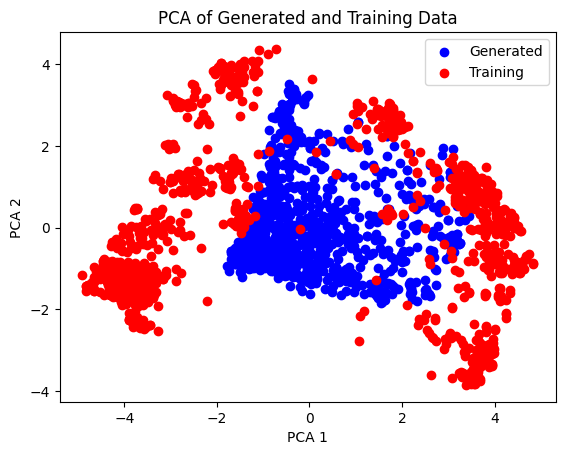

In [11]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt

PCA_model = PCA(n_components=2)
df_traning_fps = np.array(df_traning_fps)
df_generated_fps = np.array(df_generated_fps)
generated_fps_reduced_dim = PCA_model.fit_transform(df_generated_fps)
training_fps_reduced_dim = PCA_model.fit_transform(df_traning_fps)
plt.scatter(generated_fps_reduced_dim[:, 0], generated_fps_reduced_dim[:, 1], c='blue', label='Generated')
plt.scatter(training_fps_reduced_dim[:, 0], training_fps_reduced_dim[:, 1], c='red', label='Training')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Generated and Training Data')
plt.legend()

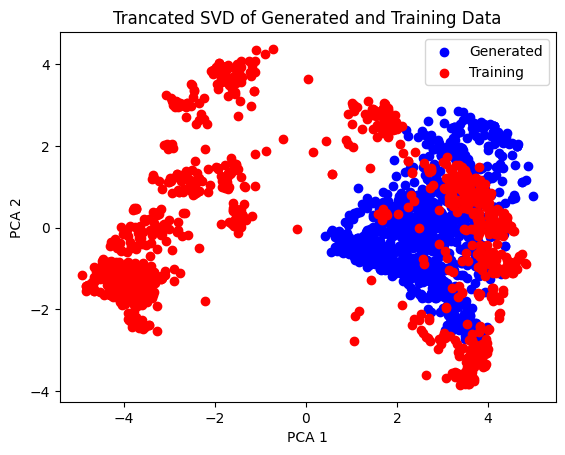

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

truncated_SVD_model = TruncatedSVD(n_components=2)
generated_fps_reduced_dim_svd = truncated_SVD_model.fit_transform(df_generated_fps)
training_fps_reduced_dim_svd = truncated_SVD_model.fit_transform(df_traning_fps)
plt.scatter(generated_fps_reduced_dim_svd[:, 0], generated_fps_reduced_dim_svd[:, 1], c='blue', label='Generated')
plt.scatter(training_fps_reduced_dim[:, 0], training_fps_reduced_dim[:, 1], c='red', label='Training')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Trancated SVD of Generated and Training Data')
plt.legend()


### Now let's do the same comparison the generated compounds with the starting population.

In [13]:
with open("./start_population/chembl50k_best_act.smi", "rb") as f:
    start_population_smiles = f.readlines()
start_population_smiles = [smi.decode("utf-8").strip() for smi in start_population_smiles]
df_start_pop_fps = []
for smi in start_population_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048).ToList()
        df_start_pop_fps.append(mol_fps)
df_start_pop_fps = np.array(df_start_pop_fps)

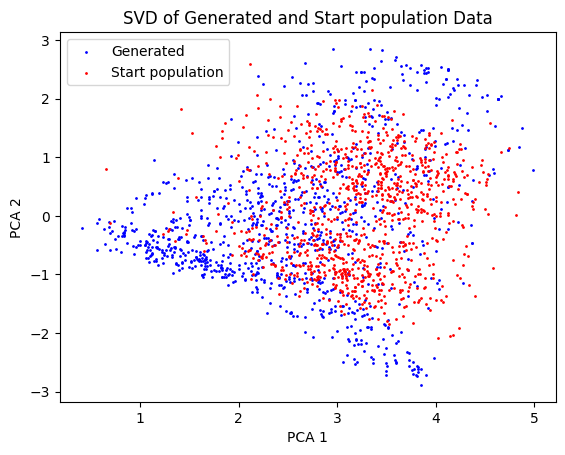

In [14]:
truncated_SVD_model = TruncatedSVD(n_components=2)
start_pop_fps_reduced_dim_svd = truncated_SVD_model.fit_transform(df_start_pop_fps)
generated_fps_reduced_dim_svd = truncated_SVD_model.fit_transform(df_generated_fps)
start_pop_fps_reduced_dim_svd_reduced_ind = np.random.choice(start_pop_fps_reduced_dim_svd.shape[0], generated_fps_reduced_dim_svd.shape[0], replace=False)
start_pop_fps_reduced_dim_svd_reduced = start_pop_fps_reduced_dim_svd[start_pop_fps_reduced_dim_svd_reduced_ind]
plt.scatter(generated_fps_reduced_dim_svd[:, 0], generated_fps_reduced_dim_svd[:, 1], c='blue', label='Generated', s=1)
plt.scatter(start_pop_fps_reduced_dim_svd_reduced[:, 0], start_pop_fps_reduced_dim_svd_reduced[:, 1], c='red', label='Start population', s=1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('SVD of Generated and Start population Data')
plt.legend()